In [131]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


In [132]:
pd.set_option("display.max_rows", 20, "display.max_columns", None)


In [133]:
# import the shots dataset
shots = pd.read_csv("/Users/harrisonward/Desktop/CS/Git/xG/datasets/23_24_shotmaps.csv", index_col='Unnamed: 0')

shots = shots.fillna(0)


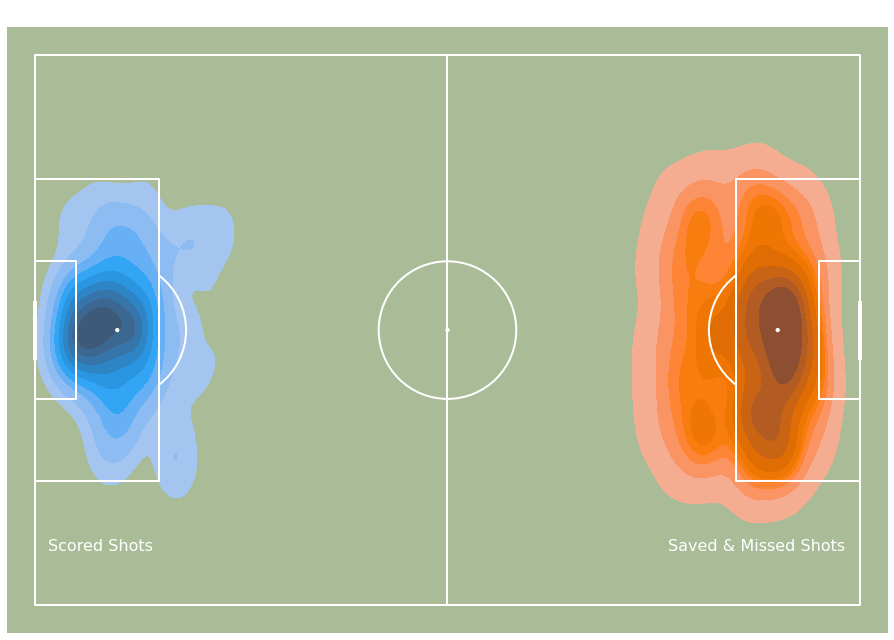

In [164]:
# create a split view plot
pitch = Pitch(
    pitch_color="#aabb97",
    line_color="white",
    stripe=False,
)

fig, ax = pitch.draw(figsize=(16, 9))

sns.kdeplot(
    x=shots[shots["outcome_goal"] == 1]['playerCoordinates.x'] + 2.5,
    y=90 - shots[shots["outcome_goal"] == 1]['playerCoordinates.y'],
    fill=True,
    zorder=-1,
    alpha=1,
    label="Goal",
)

sns.kdeplot(
    x=117.5 - shots[shots["outcome_goal"] == 0]['playerCoordinates.x'],
    y=90 - shots[shots["outcome_goal"] == 0]['playerCoordinates.y'],
    fill=True,
    zorder=-1,
    alpha=1,
    label="No Goal",
)

ax.annotate("Scored Shots", xy=(2, 72), c="White", fontsize=16)
ax.annotate("Saved & Missed Shots", xy=(92, 72), c="White", fontsize=16)

plt.title("Shotmap from Premier League Games 2023-2024 Season", c="White", fontsize=20)

plt.savefig("/Users/harrisonward/Desktop/CS/Git/xG/assets/shotmap.png")
# plt.show()

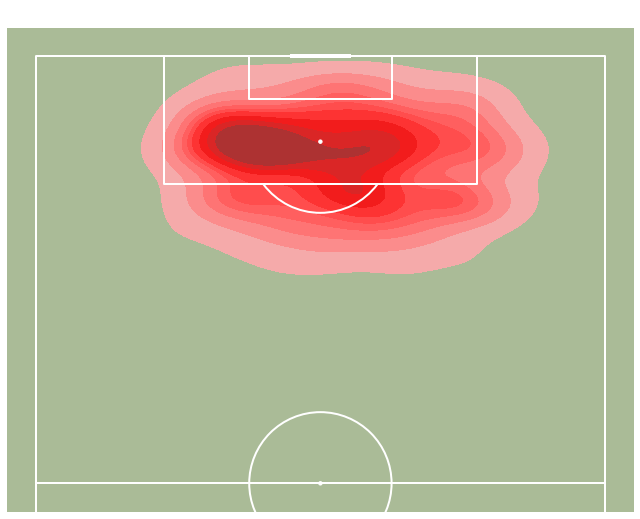

In [135]:
# create a split view plot
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True, 
    pitch_length=105,
    pitch_width=68,
)

fig, ax = pitch.draw(figsize=(9, 9))

sns.kdeplot(
    x=shots[shots["outcome_block"] == 1]['playerCoordinates.y'] - 6.4,
    y=120 - shots[shots["outcome_block"] == 1]['playerCoordinates.x'],
    fill=True,
    zorder=-1,
    color='red'
)

plt.title("Density of Blocked Shots from Premier League Games 23/24", c="White", fontsize=20)


plt.savefig("/Users/harrisonward/Desktop/CS/Git/xG/assets/blocked_map.png")
# plt.show()

In [136]:
span = shots[shots["outcome_miss"] == 0]['goalMouthCoordinates.y'].values
goal_mouth_y_span = min(span), max(span)

player_x_span = shots['playerCoordinates.x'].values
player_y_span = shots['playerCoordinates.y'].values

# print('Goalmouth span:', *goal_mouth_y_span)
# print('Player x span:',  min(player_x_span), max(player_x_span))
# print('Player y span:', min(player_y_span), max(player_y_span))

Goalmouth span: 44.3 55.6
Player x span: 0.8 54.6
Player y span: 6.4 80.0


## Feature Engineneering

In [137]:
# calculate angle between ball and goal mouth
left_post = np.array([0, 44.3])
right_post = np.array([0, 55.5])

def distance_to_posts(shot_location:np.array, left_post:np.array, right_post:np.array):
    """
    Calculate the distances from a shot location to the left and right goal posts.

    Parameters:
    - shot_location (numpy.ndarray): An array containing the (x, y) coordinates of the shot location.
    - left_post (numpy.ndarray): An array containing the (x, y) coordinates of the left goal post.
    - right_post (numpy.ndarray): An array containing the (x, y) coordinates of the right goal post.

    Returns:
    - tuple: A tuple containing the distances to the left post, right post, and the distance between the posts.

    This function calculates the Euclidean distances from a shot location to the left and right goal posts
    and also computes the distance between the left and right goal posts.

    Example usage:
    distance_to_posts(np.array([10.0, 50.0]), np.array([0.0, 44.3]), np.array([0.0, 55.5]))
    """
    distance_to_left_post = np.sqrt(np.square(shot_location[:,0] - left_post[0]) + np.square(shot_location[:,1] - left_post[1]))
    distance_to_right_post = np.sqrt(np.square(shot_location[:,0] - right_post[0]) + np.square(shot_location[:,1] - right_post[1]))
    distance_between_posts = np.sqrt(np.square(right_post[1] - left_post[1]))

    return distance_to_left_post, distance_to_right_post, distance_between_posts

def goalmouth_angle(shot_location:np.array, left_post:np.array, right_post:np.array, degrees=False):
    """
    Calculate the angle between the shot location and the left and right goal posts.

    Parameters:
    - shot_location (numpy.ndarray): An array containing the (x, y) coordinates of the shot location.
    - left_post (numpy.ndarray): An array containing the (x, y) coordinates of the left goal post.
    - right_post (numpy.ndarray): An array containing the (x, y) coordinates of the right goal post.
    - degrees (bool, optional): If True, the angle is returned in degrees; if False (default), it's in radians.

    Returns:
    - float: The angle between the shot location and the goal posts.

    This function calculates the angle between the shot location and the left and right goal posts
    using the law of cosines.

    Example usage:
    goalmouth_angle(np.array([10.0, 50.0]), np.array([0.0, 44.3]), np.array([0.0, 55.5]))
    """
    a, b, c = distance_to_posts(shot_location, left_post, right_post)
    num = np.square(a) + np.square(b) - np.square(c)
    denom = 2 * a * b

    theta = np.arccos(num / denom)

    if degrees:
        theta *= 180 / np.pi

    return theta

In [138]:
shot_locations = shots[['playerCoordinates.x', 'playerCoordinates.y']].values
shots['shot.angle'] = goalmouth_angle(shot_locations, left_post, right_post, degrees=True)
shots['shot.distance'] = np.average(distance_to_posts(shot_locations, left_post, right_post)[:-1], axis=0)

In [139]:
y = shots.outcome_goal
X = shots[
    [
        "playerCoordinates.x",
        "playerCoordinates.y",
        "playerCoordinates.z",
        "goalMouthCoordinates.x",
        "goalMouthCoordinates.y",
        "goalMouthCoordinates.z",
        "shot_sit_assisted",
        "shot_sit_corner",
        "shot_sit_free-kick",
        "shot_sit_set-piece",
        "bodyPart_left-foot",
        "bodyPart_right-foot",
        "shot.angle",
    ]
]

## Model Architecture & Compiling

In [140]:
tf.random.set_seed(111)

In [141]:
# split the data
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=111
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [142]:
xg_model = keras.Sequential()

xg_model.add(layers.Input(shape=X_train.shape[1]))

xg_model.add(layers.Dense(8, activation="tanh", input_shape=(X_train.shape,)))
xg_model.add(layers.Dense(16, activation="tanh"))
xg_model.add(layers.Dense(32, activation="tanh"))
xg_model.add(layers.Dropout(0.2))
xg_model.add(layers.Dense(64, activation="tanh"))

xg_model.add(layers.Dense(1, activation="sigmoid"))

In [143]:
xg_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 112       
                                                                 
 dense_21 (Dense)            (None, 16)                144       
                                                                 
 dense_22 (Dense)            (None, 32)                544       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                2112      
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,977
Trainable params: 2,977
Non-traina

In [144]:
xg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    patience=15,
    mode="min",
    monitor="val_loss",
    restore_best_weights=True,
)
# story history
xg_history = xg_model.fit(
    X_train, y_train, validation_split=0.2, callbacks=callback, epochs=200, verbose=1
)

Epoch 1/200


39/39 [==============================] - 1s 5ms/step - loss: 0.5854 - accuracy: 0.7326 - val_loss: 0.4348 - val_accuracy: 0.8660
Epoch 2/200
39/39 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.8774 - val_loss: 0.2678 - val_accuracy: 0.9085
Epoch 3/200
39/39 [==============================] - 0s 2ms/step - loss: 0.2927 - accuracy: 0.8929 - val_loss: 0.2333 - val_accuracy: 0.9150
Epoch 4/200
39/39 [==============================] - 0s 2ms/step - loss: 0.2831 - accuracy: 0.9011 - val_loss: 0.2355 - val_accuracy: 0.9150
Epoch 5/200
39/39 [==============================] - 0s 2ms/step - loss: 0.2713 - accuracy: 0.9019 - val_loss: 0.2333 - val_accuracy: 0.9183
Epoch 6/200
39/39 [==============================] - 0s 2ms/step - loss: 0.2649 - accuracy: 0.9019 - val_loss: 0.2313 - val_accuracy: 0.9183
Epoch 7/200
39/39 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.9035 - val_loss: 0.2298 - val_accuracy: 0.9183
Epoch 8/200
39/39 [======

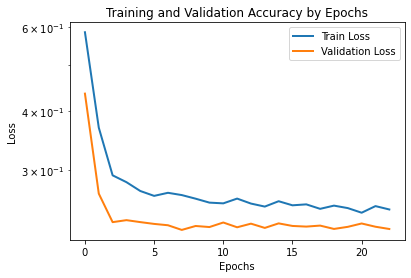

In [145]:
# plt.title("Training and Validation Accuracy by Epochs")
# plt.semilogy(xg_history.history["loss"], label="Train Loss", linewidth=2)
# plt.semilogy(xg_history.history["val_loss"], label="Validation Loss", linewidth=2)
# plt.legend()

# # Set the axes labels
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

### Alternate models for comparision

In [146]:
results = {}
for depth in range(1, 20):
    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train, y_train)

    rf_pred_test = clf.predict_proba(X_test)[:,1]
    results[depth] = mean_squared_error(y_test, rf_pred_test)
    
optimal_depth = min(results, key=results.get)
print(f'Optimal depth is {optimal_depth}')

Optimal depth is 12


In [147]:
clf = RandomForestClassifier(max_depth=optimal_depth, random_state=0)
clf.fit(X_train, y_train)

rf_pred = clf.predict_proba(X_scaled)[:,1]
rf_pred_test = clf.predict_proba(X_test)[:,1]

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [149]:
results = {}
for n_estimators in np.arange(1, 10, step=1):
    clf = AdaBoostClassifier(n_estimators=n_estimators, base_estimator=svm.SVC(), random_state=0, algorithm='SAMME')
    clf.fit(X_train, y_train)

    ada_pred_test = clf.predict_proba(X_test)[:,1]
    results[n_estimators] = mean_squared_error(y_test, ada_pred_test)
    
optimal_depth = min(results, key=results.get)
print(f'Optimal number of estimators is {optimal_depth}')

Optimal number of estimators is 1


In [150]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

clf.predict_proba(X_scaled)

ada_pred_test = clf.predict_proba(X_test)[:,1]

ada_mse = mean_squared_error(y_test, ada_pred_test)

In [151]:
clf = GaussianNB()
clf.fit(X_train, y_train)

clf.predict_proba(X_scaled)

gnb_pred_test = clf.predict_proba(X_test)[:,1]

gnb_mse = mean_squared_error(y_test, gnb_pred_test)

## Generate xG Predictions

In [152]:
# predict on full data
ann_pred = xg_model.predict(X_scaled)
ann_pred_test = xg_model.predict(X_test)

In [153]:
ann_mse = mean_squared_error(y_test, ann_pred_test)
rf_mse = mean_squared_error(y_test, rf_pred_test)

print(f'ANN Model MSE: {ann_mse:0.4f}')
print(f'RF Model MSE: {rf_mse:0.4f}')
print(f'ADA Model MSE: {ada_mse:0.4f}')
print(f'GNB Model MSE: {gnb_mse:0.4f}')

ANN Model MSE: 0.0829
RF Model MSE: 0.0724
ADA Model MSE: 0.2063
GNB Model MSE: 0.6385


In [154]:
if ann_mse == min(ann_mse, rf_mse):
    shots["xG"] = ann_pred
else:
    shots['xG'] = rf_pred

## Plot xG by Player Coordinates

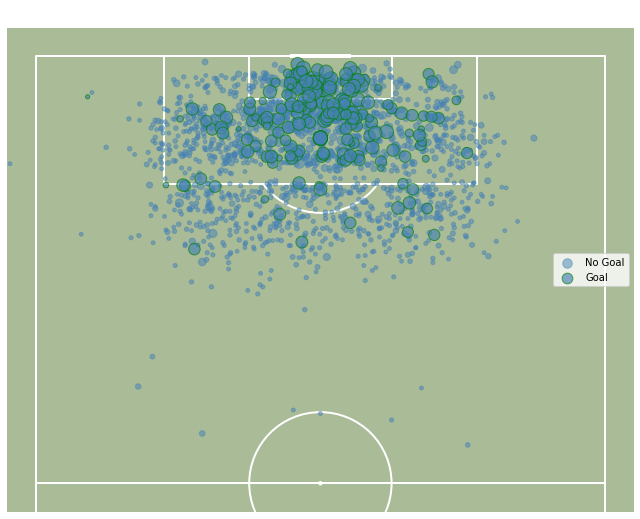

In [155]:
# create a split view plot
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True, pitch_length=105,
    pitch_width=68,
)

fig, ax = pitch.draw(figsize=(9, 9))

plt.scatter(
    x=shots[shots["outcome_goal"] == 0]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_goal"] == 0]['playerCoordinates.x'],
    alpha=0.5,
    s=200 * shots[shots["outcome_goal"] == 0].xG + 15,
    c="steelblue",
    label="No Goal",
)

plt.scatter(
    x=shots[shots["outcome_goal"] == 1]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_goal"] == 1]['playerCoordinates.x'],
    alpha=0.65,
    s=200 * shots[shots["outcome_goal"] == 1].xG + 15,
    c="steelblue",
    edgecolor="green",
    label="Goal",
)

plt.title("Shotmap from Premier League Games '2023", c="White", fontsize=20)
plt.legend()

plt.savefig("/Users/harrisonward/Desktop/CS/Git/xG/assets/xg_map.png")
# plt.show()

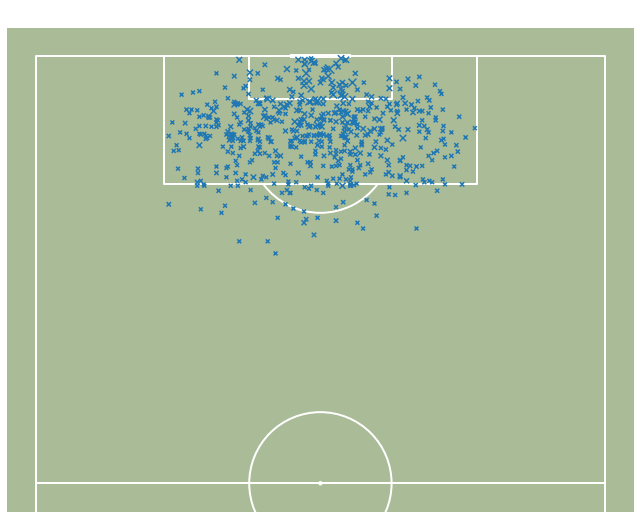

In [156]:
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True, pitch_length=105,
    pitch_width=68,
)

fig, ax = pitch.draw(figsize=(9, 9))

plt.scatter(
    x=shots[shots["outcome_block"] == 1]['blockCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_block"] == 1]['blockCoordinates.x'],
    marker='x',
    s=200 * shots[shots["outcome_block"] == 1].xG + 15,
)

plt.title("Map of Blocked Shots from Premier League Games 23/24", c="White", fontsize=20)


plt.savefig("/Users/harrisonward/Desktop/CS/Git/xG/assets/blocked_map.png")
# plt.show()

## Compile xG stats by player and team

In [157]:
xg_for = shots.groupby('team')['xG'].sum().sort_values(ascending=False)
xg_against = shots.groupby('opponent')['xG'].sum().sort_values(ascending=False)


xg_table = pd.concat([xg_for, xg_against], axis=1, keys=['xG', 'xGA'])
xg_table['xG_differential'] = xg_table['xG'] - xg_table['xGA']

In [158]:
xg_table = xg_table.sort_values(by='xG_differential', ascending=False)
xg_table['Team'] = xg_table.index
xg_table.reset_index(drop=True, inplace=True)
xg_table.index = range(1, xg_table.shape[0] + 1)

In [165]:
# sort columns alphabetically
desired_columns = sorted([col for col in xg_table.columns])

# Reorder the columns based on the desired order
xg_table = xg_table[desired_columns]
xg_table['xG'] = xg_table['xG'].map('{:,.2f}'.format)
xg_table['xGA'] = xg_table['xGA'].map('{:,.2f}'.format)
xg_table['xG_differential'] = xg_table['xG_differential'].map('{:,.2f}'.format)

xg_table = xg_table.rename(columns={'xG_differential': 'xG Differential'})

xg_table.to_markdown('/Users/harrisonward/Desktop/CS/Git/xG/assets/xG_table.md', index=True)
xg_table.to_csv('/Users/harrisonward/Desktop/CS/Git/xG/assets/xG_table.csv', index=True)
xg_table.head(20)

ValueError: Unknown format code 'f' for object of type 'str'

### Player xG table

In [160]:
xg_by_player = pd.DataFrame(shots.groupby('player.name')['xG'].sum().sort_values(ascending=False))

player_team = shots[['player.name', 'player.position', 'team']].drop_duplicates(subset='player.name')

xg_by_player = xg_by_player.merge(player_team, how='left', left_on='player.name', right_on='player.name')
xg_by_player.reset_index(drop=True, inplace=True)
xg_by_player.index = range(1, len(xg_by_player) + 1)

xg_by_player = xg_by_player.rename(columns={'player.name': 'Player', 'player.position': 'Position', 'team': 'Team'})
xg_by_player = xg_by_player[['Player', 'Team', 'Position', 'xG']]
xg_by_player['xG'] = xg_by_player['xG'].map('{:,.2f}'.format)

xg_by_player.head(20).to_markdown('/Users/harrisonward/Desktop/CS/Git/xG/assets/xG_by_player.md', index=True)
xg_by_player.head(20)

,Player,Team,Position,xG
1,Erling Haaland,Manchester City,F,6.75
2,Jarrod Bowen,West Ham United,M,4.95
3,Alexander Isak,Newcastle United,F,4.49
4,Bukayo Saka,Arsenal,F,4.17
5,Bryan Mbeumo,Brentford,F,3.94
6,Heung-min Son,Tottenham Hotspur,F,3.85
7,Odsonne Édouard,Crystal Palace,F,3.55
8,Callum Wilson,Newcastle United,F,3.48
9,Evan Ferguson,Brighton & Hove Albion,F,3.44
10,Ollie Watkins,Aston Villa,F,3.43


### Player xG tables, normalized

In [163]:
# sum the xG by player
xg_by_player = pd.DataFrame(shots.groupby('player.name')[
                            'xG'].sum().sort_values(ascending=False))

# sum the minutes and matches played
minutes_played = pd.DataFrame(shots.groupby(['player.name', 'event.id', 'id'])[
                              'statistics.minutesPlayed'].sum())
minutes_played = pd.DataFrame(minutes_played.groupby(
    'player.name')['statistics.minutesPlayed'].sum())
shots_taken = pd.DataFrame(shots.groupby('player.name')['id'].count())
total_matches = pd.DataFrame(shots.groupby('player.name')[
                             'event.id'].nunique()).reset_index()

# merge the dfs
per_ninety_table = xg_by_player.merge(minutes_played, how='left', on='player.name').merge(
    total_matches, how='left', on='player.name').merge(shots_taken, how='left', on='player.name')

per_ninety_table['minutes_played'] = (
    per_ninety_table['statistics.minutesPlayed'] / per_ninety_table['id']) * per_ninety_table['event.id']
per_ninety_table['xG_per_ninety'] = ((
    per_ninety_table['event.id'] * 90 / per_ninety_table['minutes_played']) * per_ninety_table['xG']) / per_ninety_table['event.id']
per_ninety_table['xG_per_attempt'] = per_ninety_table['xG'] / \
    per_ninety_table['id']


# format the number of decimal places
numeric_columns = list(per_ninety_table.columns[1:].values)
per_ninety_table[numeric_columns] = per_ninety_table[numeric_columns].applymap(
    '{:,.2f}'.format)

# merge in the team and postion
player_team = shots[['player.name', 'player.position',
                     'team']].drop_duplicates(subset='player.name')
per_ninety_table = per_ninety_table.merge(
    player_team, how='left', on='player.name')


# rename and re-order columns, helper columns are dropped in the interim
ordered_columns = ['player.name', 'team', 'player.position', 'xG_per_ninety', 'xG_per_attempt', 'xG', 'minutes_played', 'id']
per_ninety_table = per_ninety_table[ordered_columns]
per_ninety_table = per_ninety_table.rename(columns={'player.name': 'Player', 'player.position': 'Position', 'team': 'Team',
                                           'xG_per_ninety': 'xG per 90 Minutes', 'xG_per_attempt': 'xG per Attempt',
                                           'minutes_played': 'Minutes', 'id': 'Attempts'})
per_ninety_table[['Minutes', 'Attempts']] = per_ninety_table[['Minutes', 'Attempts']].astype(float).applymap('{:,.0f}'.format) 


# reset and renumber index
per_ninety_table.sort_values(by='xG per 90 Minutes', ascending=False).head(20)
per_ninety_table.reset_index(drop=True, inplace=True)
per_ninety_table.index = range(1, len(per_ninety_table) + 1) 

per_ninety_table.to_markdown('/Users/harrisonward/Desktop/CS/Git/xG/assets/xG_by_player_per_90.md', index=True)
per_ninety_table.head(20)



In [162]:
shots.to_csv('/Users/harrisonward/Desktop/CS/Git/xG/datasets/23_24_shotmaps_augmented.csv')